## Data Preprocessing

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

file_path = '83.csv'  # Adjust the file path if needed
data = pd.read_csv(file_path, na_values='.')
data.loc[:, 'Species_Sex'] = data['Species'] + '_' + data['Sex']

selected_columns = ['Latitude', 'Temperature', 'Thorax_length','l2','l3p','l3d','lpd','l3','w1','w2','w3','wing_loading', 'Species_Sex']
data_selected = data[selected_columns]

# Drop rows with missing values
data_prepared = data_selected.dropna().copy()
data_prepared.reset_index(drop=True, inplace=True)

numeric_features = ['Latitude', 'Temperature', 'Thorax_length','l2','l3p','l3d','lpd','l3','w1','w2','w3','wing_loading']
categorical_feature = 'Species_Sex'

label_encoder = LabelEncoder()
data_prepared[categorical_feature] = label_encoder.fit_transform(data_prepared[categorical_feature])

In [2]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print(label_mapping)

{'D._aldrichi_female': 0, 'D._aldrichi_male': 1, 'D._buzzatii_female': 2, 'D._buzzatii_male': 3}


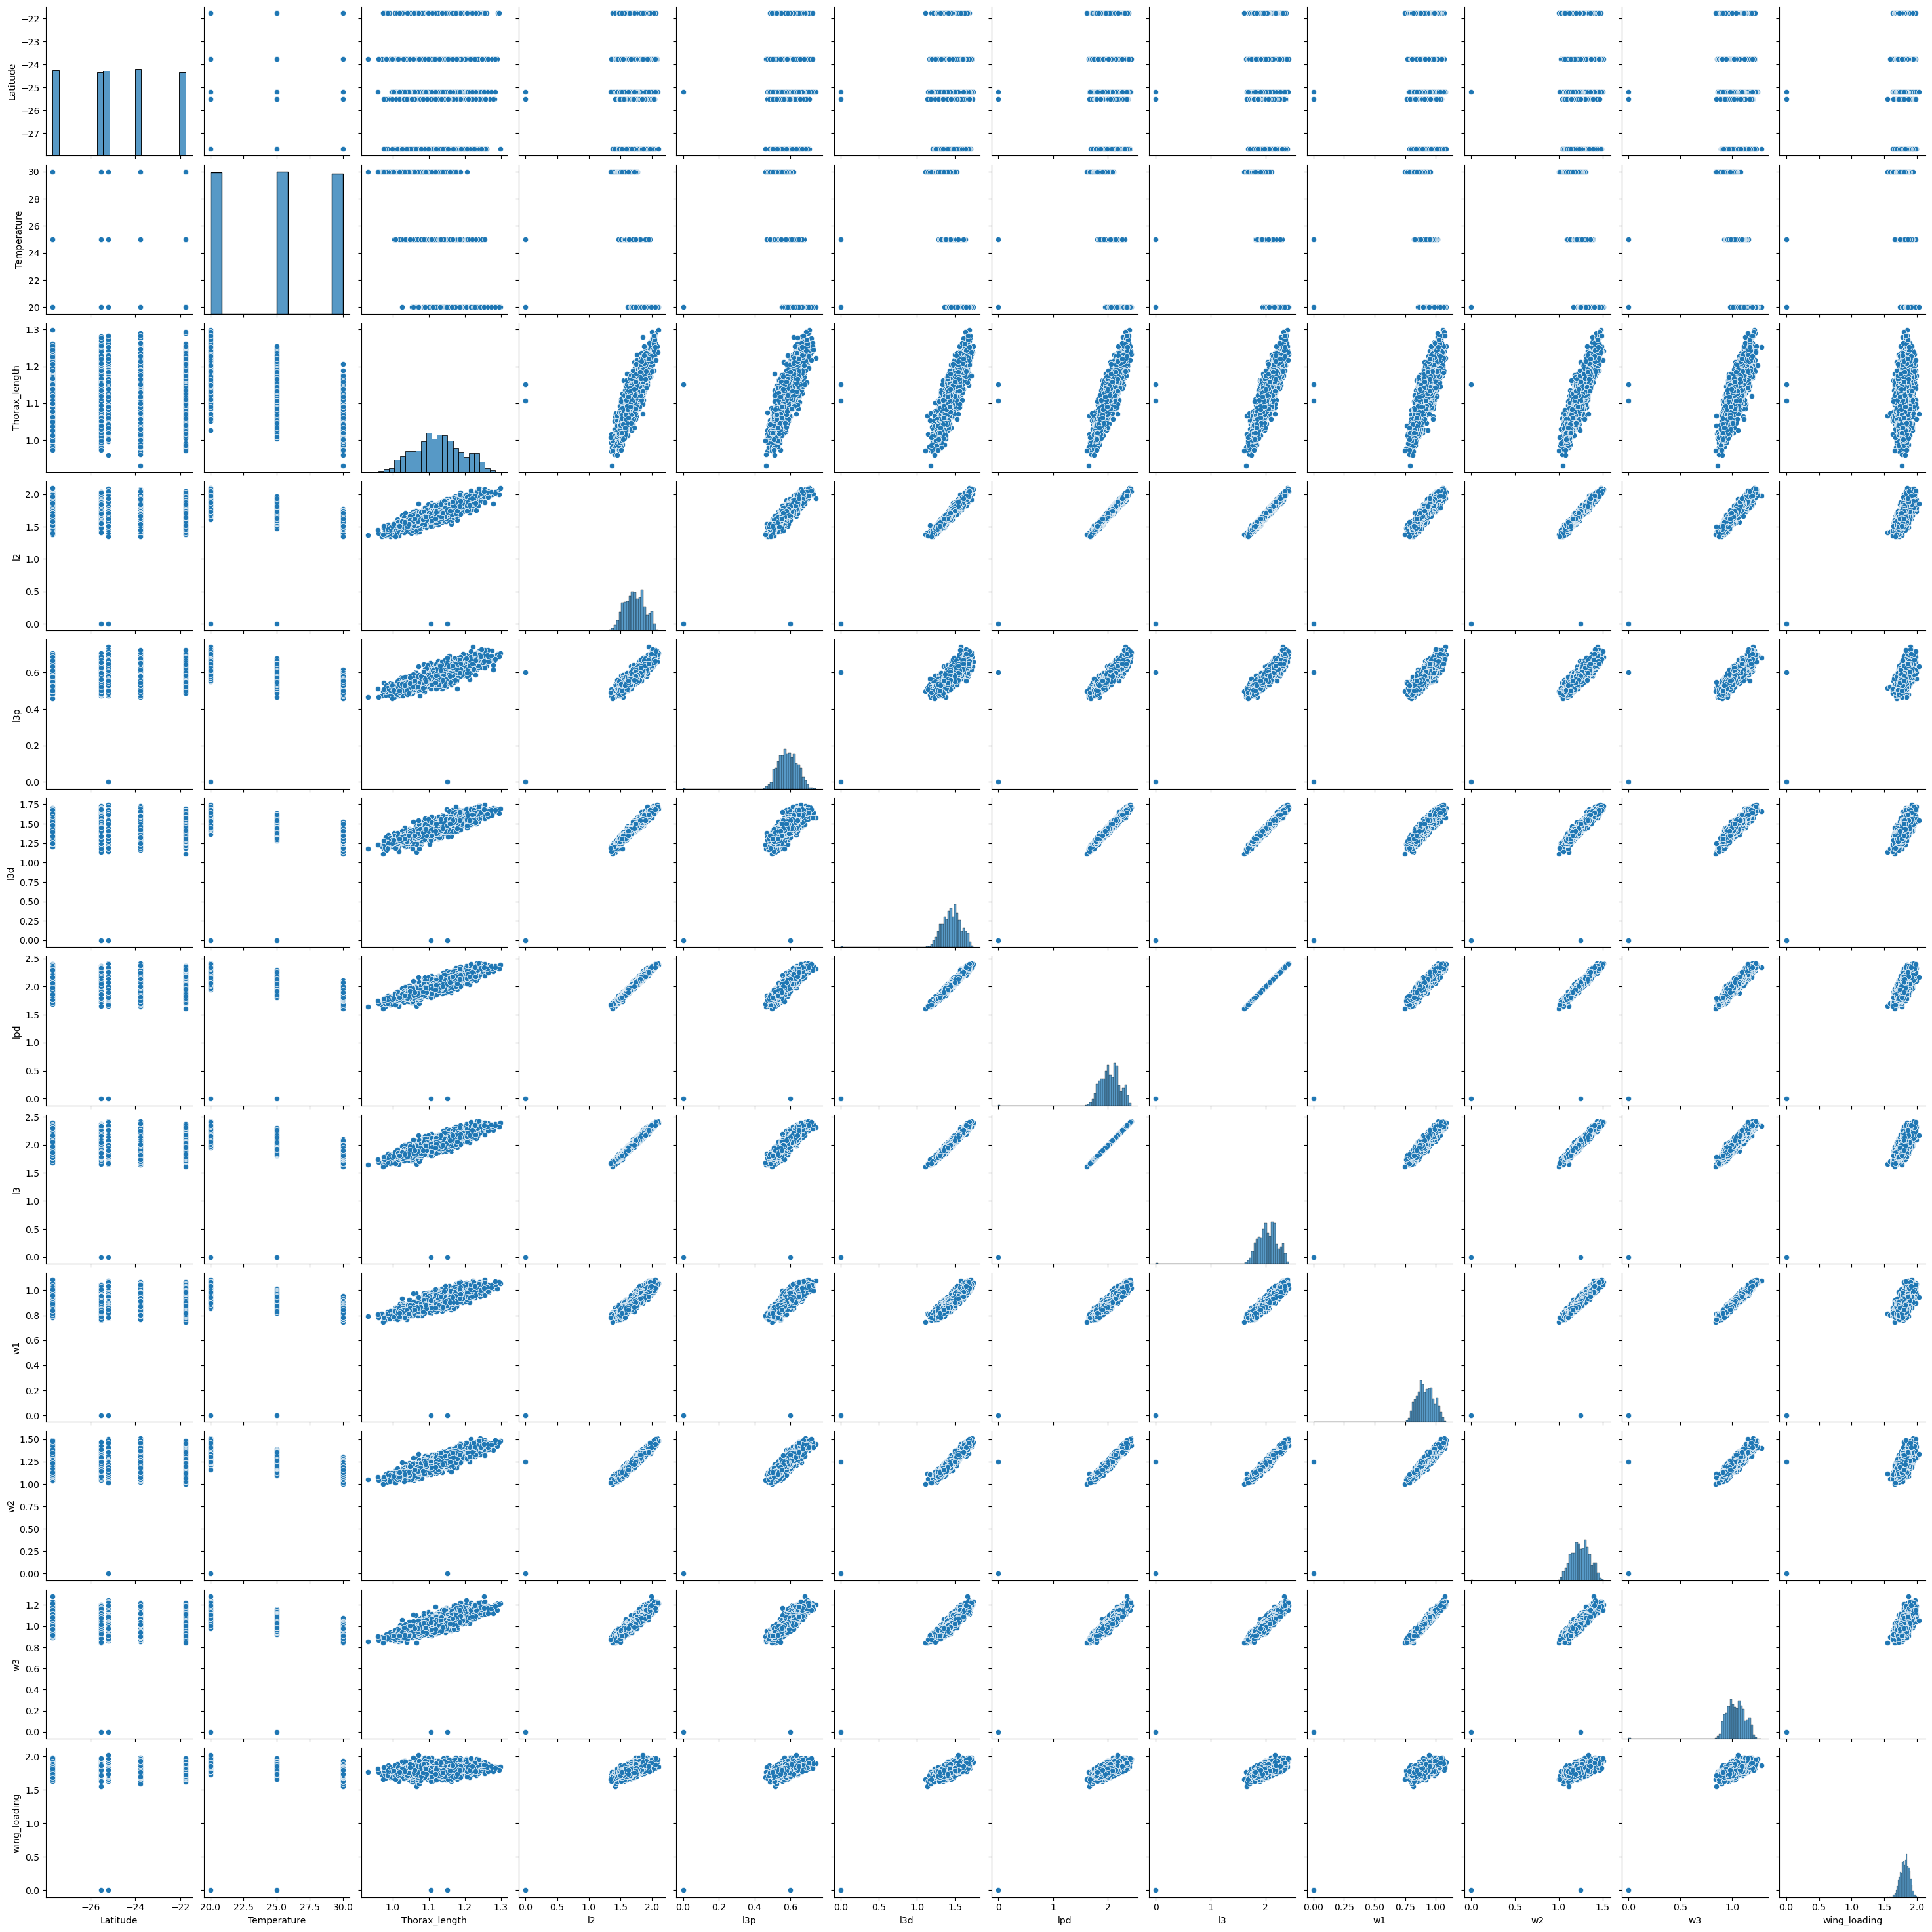

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(data_prepared[numeric_features])
plt.show()


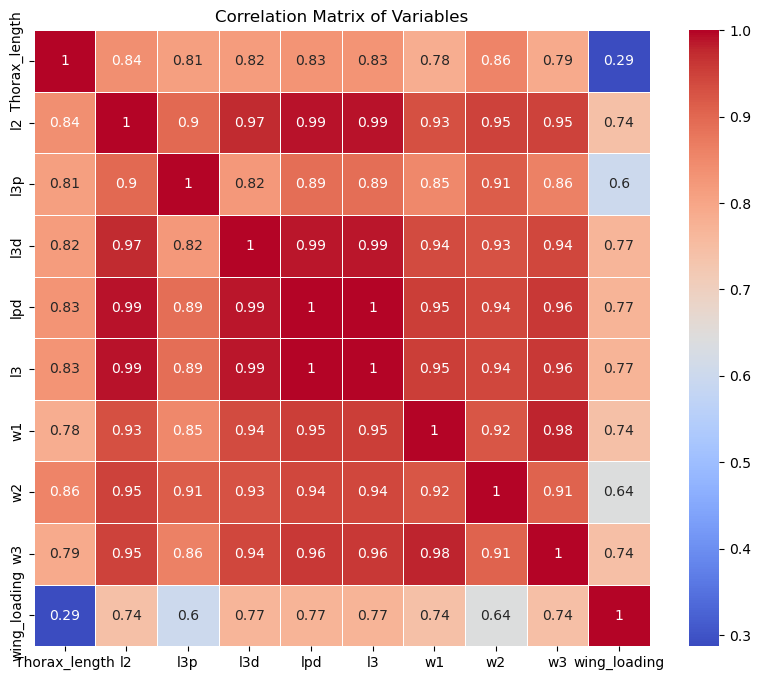

In [4]:
variables = ['Thorax_length', 'l2', 'l3p', 'l3d', 'lpd', 'l3', 'w1', 'w2', 'w3', 'wing_loading']

correlation_matrix = data_prepared[variables].corr()

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, square=True)

plt.title('Correlation Matrix of Variables')

plt.show()

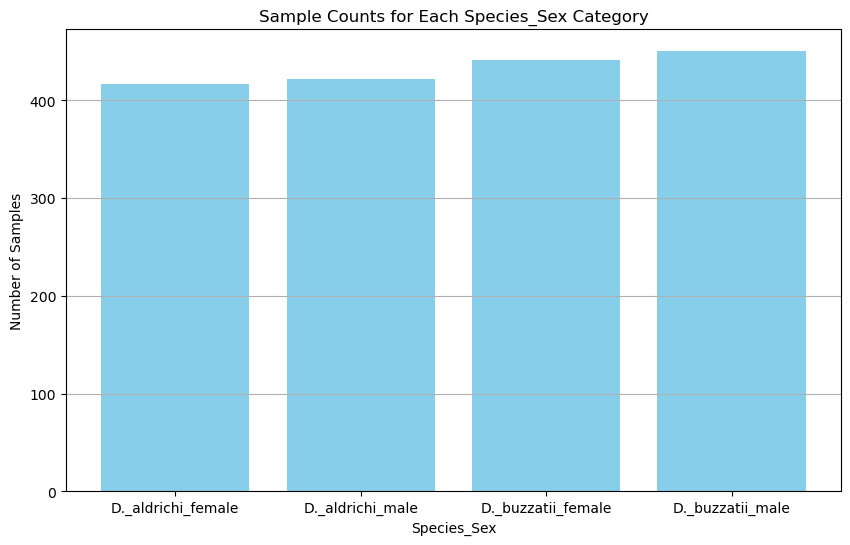

In [5]:
inverse_label_mapping = {v: k for k, v in label_mapping.items()}

category_counts = data_prepared[categorical_feature].value_counts().sort_index()

category_labels = [inverse_label_mapping[i] for i in category_counts.index]

plt.figure(figsize=(10, 6))
plt.bar(category_labels, category_counts.values, color='skyblue')

plt.title('Sample Counts for Each Species_Sex Category')
plt.xlabel('Species_Sex')
plt.ylabel('Number of Samples')

plt.grid(axis='y')
plt.show()

### Set Seed

In [6]:
import numpy as np
import torch
import random
seed = 1
torch.use_deterministic_algorithms(True)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [7]:
from sklearn.model_selection import train_test_split

X = data_prepared.drop(columns=[categorical_feature])
y = data_prepared[categorical_feature]


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=seed)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.625, random_state=seed)


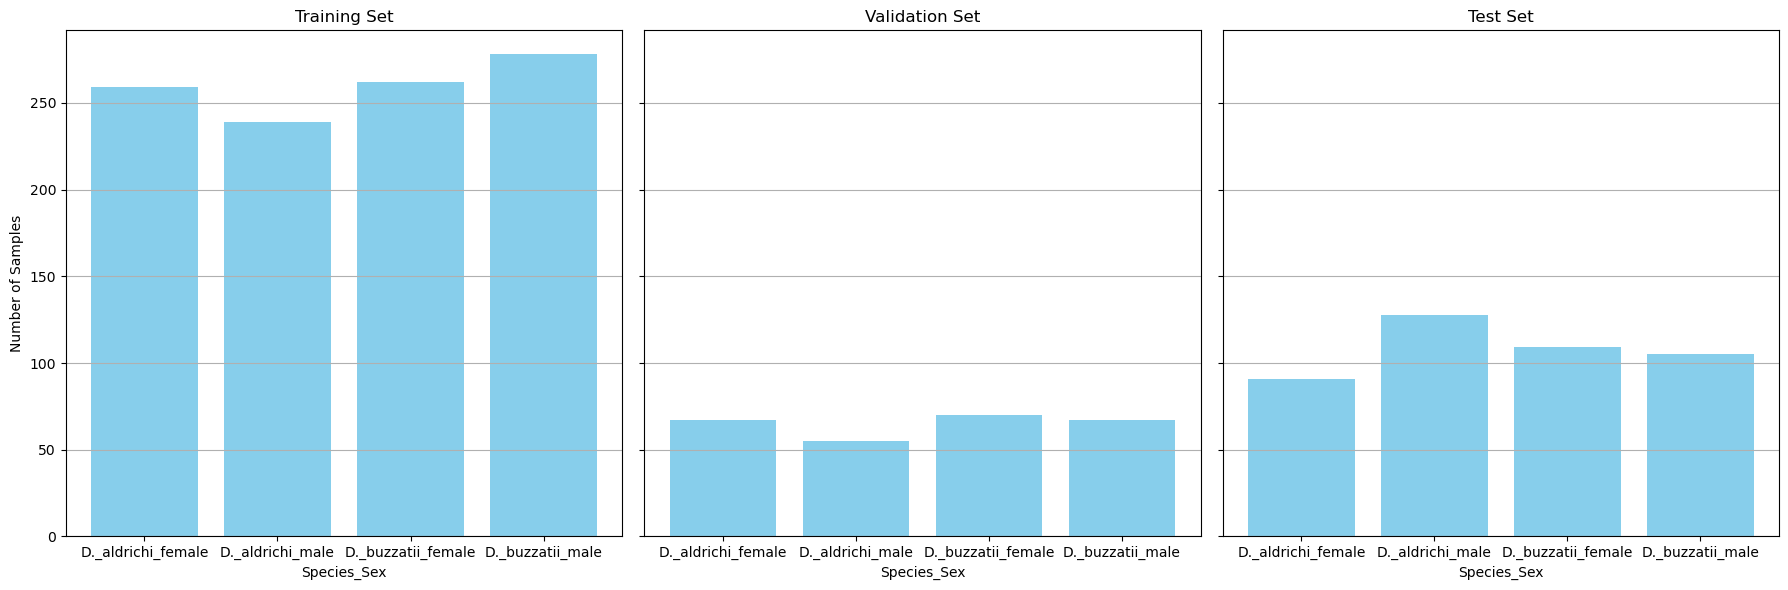

In [8]:
import matplotlib.pyplot as plt

inverse_label_mapping = {v: k for k, v in label_mapping.items()}

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=True)

datasets = [(y_train, 'Training Set'), (y_val, 'Validation Set'), (y_test, 'Test Set')]
for ax, (data, title) in zip(axes, datasets):
    category_counts = data.value_counts().sort_index()
    category_labels = [inverse_label_mapping[i] for i in category_counts.index]
    ax.bar(category_labels, category_counts.values, color='skyblue')
    ax.set_title(title)
    ax.set_xlabel('Species_Sex')
    ax.grid(axis='y')

axes[0].set_ylabel('Number of Samples')

plt.tight_layout()
plt.show()


## KNN

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


### Without PCA

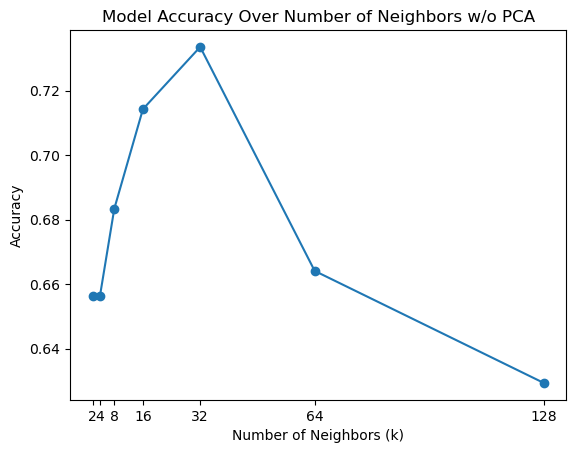

<Figure size 640x480 with 0 Axes>

In [10]:
accuracies = []
for i in range(1, 8):
    knn_classifier = KNeighborsClassifier(n_neighbors=2**i)
    knn_classifier.fit(X_train_scaled, y_train)
    y_pred = knn_classifier.predict(X_val_scaled)
    accuracy = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy)
    
x = [2**i for i in range(1, 8)]

plt.plot(x, accuracies, marker='o')
plt.xticks(x)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Number of Neighbors w/o PCA')

plt.show()
plt.clf()

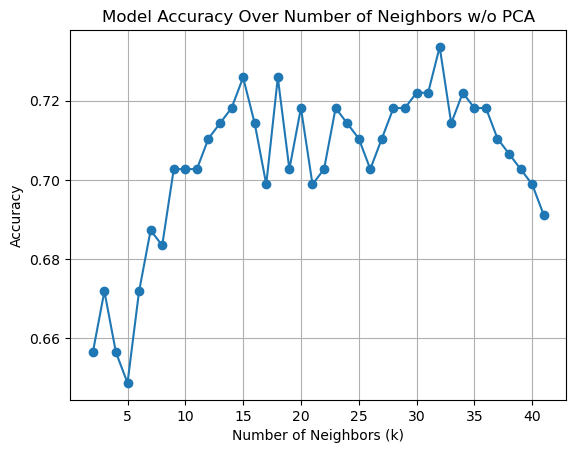

<Figure size 640x480 with 0 Axes>

In [11]:
accuracies = []
for i in range(2, 2**5+10):
    knn_classifier = KNeighborsClassifier(n_neighbors=i)
    knn_classifier.fit(X_train_scaled, y_train)
    y_pred = knn_classifier.predict(X_val_scaled)
    accuracy = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy)
    
x = range(2, 2**5+10)

plt.plot(x, accuracies, marker='o')


plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Number of Neighbors w/o PCA')

plt.grid(True)
plt.show()
plt.clf()

### Optimal setting

In [12]:
best_n = x[np.argmax(accuracies)]
knn_classifier = KNeighborsClassifier(n_neighbors=best_n)
knn_classifier.fit(X_train_scaled, y_train)
y_pred = knn_classifier.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
accuracy_knn_wo_pca = accuracy
print('best n is {} with test acc {}'.format(best_n, accuracy))

best n is 32 with test acc 0.6997690531177829


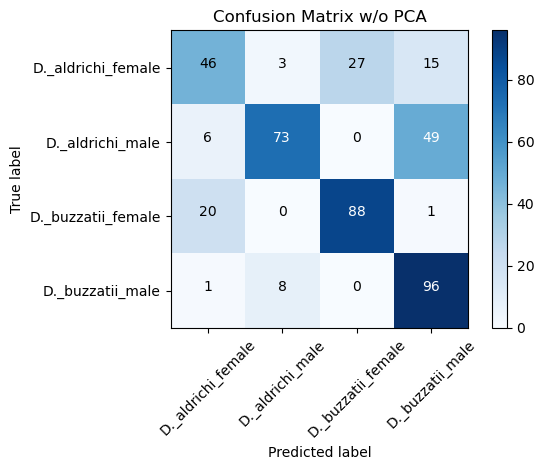

In [13]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix w/o PCA')
plt.colorbar()
tick_marks = np.arange(len(category_labels))
plt.xticks(tick_marks, category_labels, rotation=45)
plt.yticks(tick_marks, category_labels)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [14]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, target_names=category_labels, output_dict=True)

precision_recall_data = {
    "Category": [],
    "Precision": [],
    "Recall": []
}

for label in category_labels:
    precision_recall_data["Category"].append(label)
    precision_recall_data["Precision"].append(report[label]["precision"])
    precision_recall_data["Recall"].append(report[label]["recall"])

precision_recall_df_knn_wo_pca = pd.DataFrame(precision_recall_data)

print(precision_recall_df_knn_wo_pca)

             Category  Precision    Recall
0  D._aldrichi_female   0.630137  0.505495
1    D._aldrichi_male   0.869048  0.570312
2  D._buzzatii_female   0.765217  0.807339
3    D._buzzatii_male   0.596273  0.914286


### With PCA

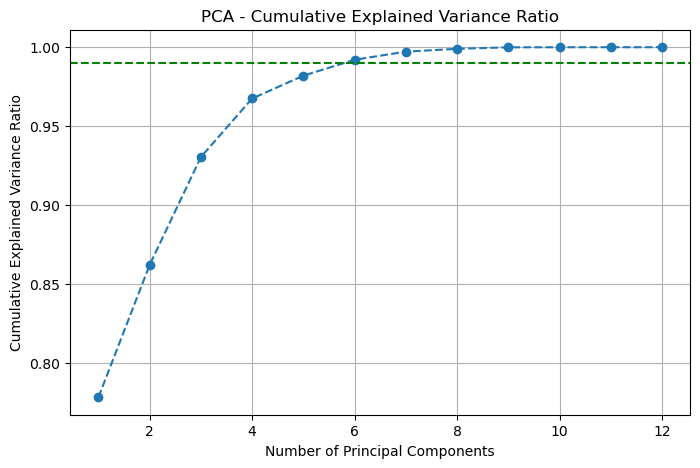

In [15]:
from sklearn.decomposition import PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.axhline(y=0.99, color='green', linestyle='--', label='0.99 Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA - Cumulative Explained Variance Ratio')
plt.grid()
plt.show()

In [16]:
n_components = np.argmax(cumulative_variance_ratio >= 0.99) + 1
print(f'Number of principal components to retain 99% variance: {n_components}')

Number of principal components to retain 99% variance: 6


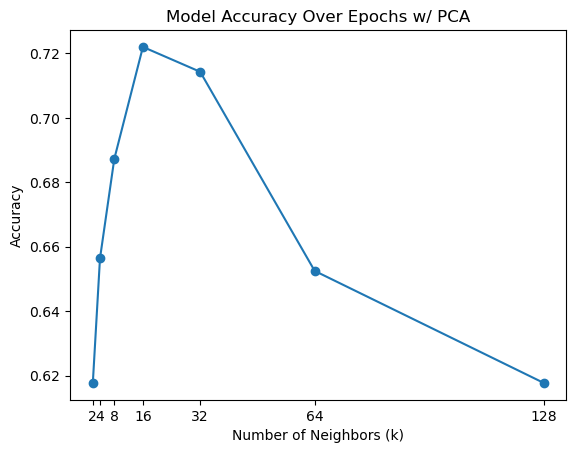

<Figure size 640x480 with 0 Axes>

In [17]:
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

accuracies = []
for i in range(1, 8):
    knn_classifier = KNeighborsClassifier(n_neighbors=2**i)
    knn_classifier.fit(X_train_pca, y_train)
    y_pred = knn_classifier.predict(X_val_pca)
    accuracy = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy)
    
x = [2**i for i in range(1, 8)]

plt.plot(x, accuracies, marker='o')
plt.xticks(x)

plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs w/ PCA')

plt.show()
plt.clf()

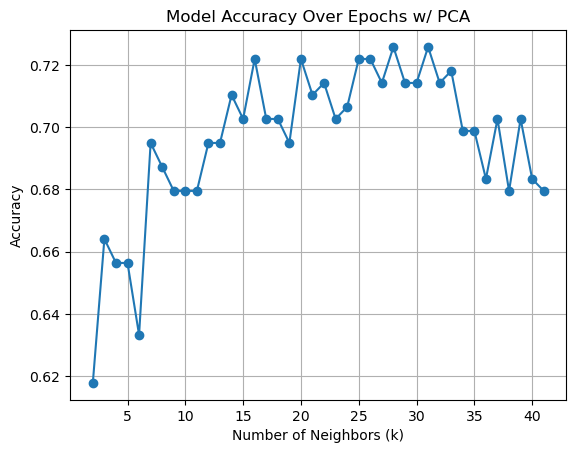

<Figure size 640x480 with 0 Axes>

In [18]:
accuracies = []
for i in range(2, 2**5+10):
    knn_classifier = KNeighborsClassifier(n_neighbors=i)
    knn_classifier.fit(X_train_pca, y_train)
    y_pred = knn_classifier.predict(X_val_pca)
    accuracy = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy)
    
x = range(2, 2**5+10)

plt.plot(x, accuracies, marker='o')

plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs w/ PCA')

plt.grid(True)
plt.show()
plt.clf()

In [19]:
best_n = x[np.argmax(accuracies)]

knn_classifier = KNeighborsClassifier(n_neighbors=best_n)
knn_classifier.fit(X_train_pca, y_train)
y_pred = knn_classifier.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
accuracy_knn_w_pca = accuracy
print('best n is {} with test acc {}'.format(best_n, accuracy))

best n is 28 with test acc 0.7066974595842956


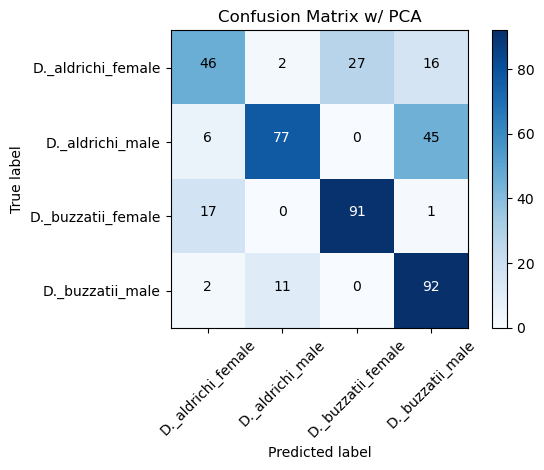

In [20]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix w/ PCA')
plt.colorbar()
tick_marks = np.arange(len(category_labels))
plt.xticks(tick_marks, category_labels, rotation=45)
plt.yticks(tick_marks, category_labels)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [21]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, target_names=category_labels, output_dict=True)

precision_recall_data = {
    "Category": [],
    "Precision": [],
    "Recall": []
}

for label in category_labels:
    precision_recall_data["Category"].append(label)
    precision_recall_data["Precision"].append(report[label]["precision"])
    precision_recall_data["Recall"].append(report[label]["recall"])

precision_recall_df_knn_w_pca = pd.DataFrame(precision_recall_data)

print(precision_recall_df_knn_w_pca)

             Category  Precision    Recall
0  D._aldrichi_female   0.647887  0.505495
1    D._aldrichi_male   0.855556  0.601562
2  D._buzzatii_female   0.771186  0.834862
3    D._buzzatii_male   0.597403  0.876190


## Linear

In [22]:
def test(model, test_loader, criterion):
    model.eval()
    y_pred = []
    test_loss = 0
    num_samples = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * len(targets)
            num_samples += len(targets)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.tolist())
    return y_pred, test_loss/num_samples

def train(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    num_samples = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss+= loss.item() * len(targets)
        num_samples += len(targets)
        loss.backward()
        optimizer.step()
    return total_loss/num_samples

### Training and Validation

In [23]:
# hyperparameters
lr = 0.001
epochs = 300
batch_size = 64
early_stopping = 20
# regularization L2

In [24]:
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

# prepare data
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.int64)

train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
train_loader_unshuffle = DataLoader(train_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)



input_size = X_train_scaled.shape[1]
num_classes = len(pd.unique(y_train))

model = nn.Linear(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
best_model = None
patience = 0
best_acc = float('-inf')
best_epoch = 0

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []
for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    train_losses.append(train_loss)
    y_pred,_ = test(model, train_loader_unshuffle, criterion)
    train_acc = accuracy_score(y_train, y_pred)
    train_accuracies.append(train_acc)
    
    y_pred, val_loss = test(model, val_loader, criterion)
    val_acc = accuracy_score(y_val, y_pred)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    if epoch % 50 == 0:
        print('{}/{} with val accuracy {}, tra acc {}'.format(epoch, epochs, val_acc, train_acc))
        
    if val_acc > best_acc:
        best_acc = val_acc
        best_model = model
        patience = 0
    else:
        patience += 1
    
    if patience == early_stopping:
        best_epoch = epoch
        break

print('best epoch at epoch {} with val acc {}'.format(best_epoch, best_acc))
        

0/300 with val accuracy 0.37065637065637064, tra acc 0.3448940269749518
50/300 with val accuracy 0.6254826254826255, tra acc 0.6734104046242775
100/300 with val accuracy 0.6911196911196911, tra acc 0.7129094412331407
best epoch at epoch 105 with val acc 0.6988416988416989


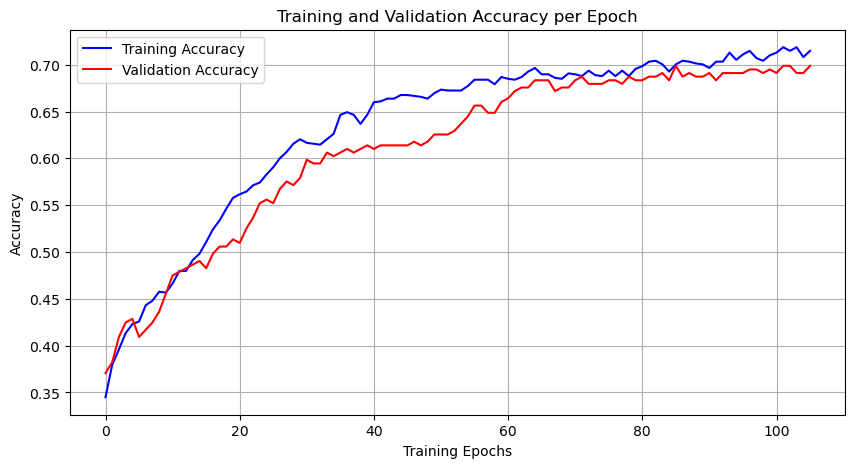

<Figure size 640x480 with 0 Axes>

In [25]:
epoch_range = range(len(val_accuracies))

plt.figure(figsize=(10, 5))
plt.plot(epoch_range, train_accuracies, label='Training Accuracy', linestyle='-', color='blue')
plt.plot(epoch_range, val_accuracies, label='Validation Accuracy', linestyle='-', color='red')

plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Training Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.grid(True)
plt.show()
plt.clf()

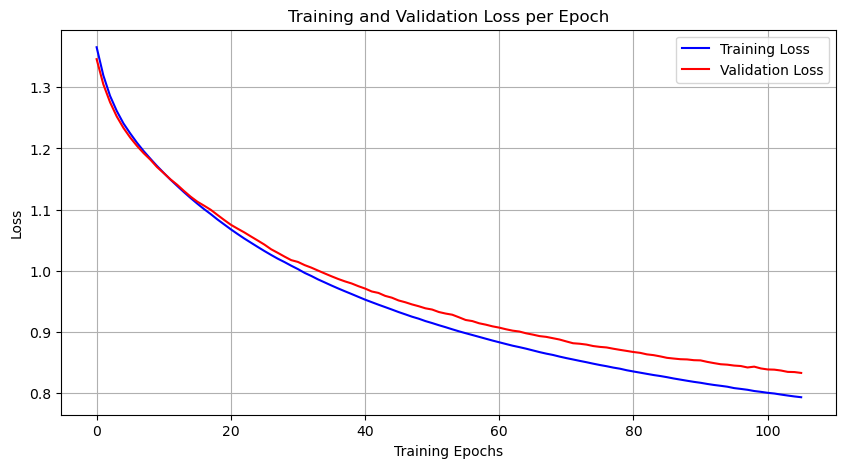

<Figure size 640x480 with 0 Axes>

In [26]:
epoch_range = range(len(val_losses))

plt.figure(figsize=(10, 5))
plt.plot(epoch_range, train_losses, label='Training Loss', linestyle='-', color='blue')
plt.plot(epoch_range, val_losses, label='Validation Loss', linestyle='-', color='red')

plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Training Epochs')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.show()
plt.clf()

In [27]:
y_pred, val_loss = test(best_model, test_loader, criterion)
test_acc = accuracy_score(y_test, y_pred)
accuracy_linear =test_acc
test_acc

0.7228637413394919

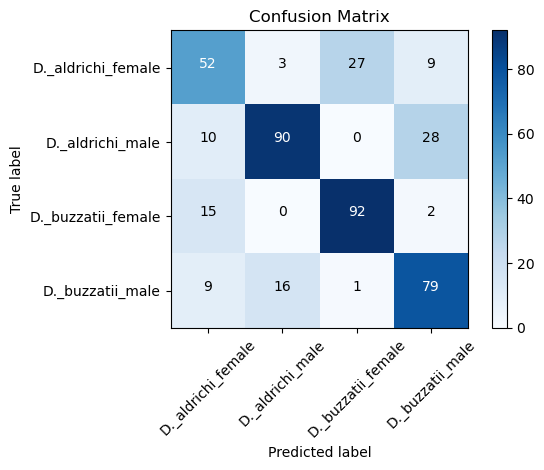

In [28]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(category_labels))
plt.xticks(tick_marks, category_labels, rotation=45)
plt.yticks(tick_marks, category_labels)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [29]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, target_names=category_labels, output_dict=True)

precision_recall_data = {
    "Category": [],
    "Precision": [],
    "Recall": []
}

for label in category_labels:
    precision_recall_data["Category"].append(label)
    precision_recall_data["Precision"].append(report[label]["precision"])
    precision_recall_data["Recall"].append(report[label]["recall"])

precision_recall_df_linear = pd.DataFrame(precision_recall_data)

print(precision_recall_df_linear)

             Category  Precision    Recall
0  D._aldrichi_female   0.604651  0.571429
1    D._aldrichi_male   0.825688  0.703125
2  D._buzzatii_female   0.766667  0.844037
3    D._buzzatii_male   0.669492  0.752381


## MLP

In [30]:
# hyperparameters
lr = 0.001
epochs = 300
hidden_size = 64
batch_size = 64
early_stopping = 20
weight_decay = 0
# regularization L2

In [31]:
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

# prepare data
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.int64)

train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
train_loader_unshuffle = DataLoader(train_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)



input_size = X_train_scaled.shape[1]
num_classes = len(pd.unique(y_train))


class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)  # 第一层（隐藏层）
        self.relu = nn.ReLU()                             # 激活函数
        self.layer2 = nn.Linear(hidden_size, output_size) # 第二层（输出层）

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x


model = MLP(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)
best_model = None
patience = 0
best_acc = float('-inf')
best_epoch = 0

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []
for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    train_losses.append(train_loss)
    y_pred,_ = test(model, train_loader_unshuffle, criterion)
    train_acc = accuracy_score(y_train, y_pred)
    train_accuracies.append(train_acc)
    
    y_pred, val_loss = test(model, val_loader, criterion)
    val_acc = accuracy_score(y_val, y_pred)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    if epoch % 50 == 0:
        print('{}/{} with val accuracy {}, tra acc {}'.format(epoch, epochs, val_acc, train_acc))
    
    if val_acc > best_acc:
        best_acc = val_acc
        best_model = model
        patience = 0
    else:
        patience += 1
    
    if patience == early_stopping:
        best_epoch = epoch
        break
    
    
print('best epoch at epoch {} with val acc {}'.format(best_epoch, best_acc))
        

0/300 with val accuracy 0.37065637065637064, tra acc 0.36897880539499034
50/300 with val accuracy 0.7606177606177607, tra acc 0.7880539499036608
best epoch at epoch 78 with val acc 0.7760617760617761


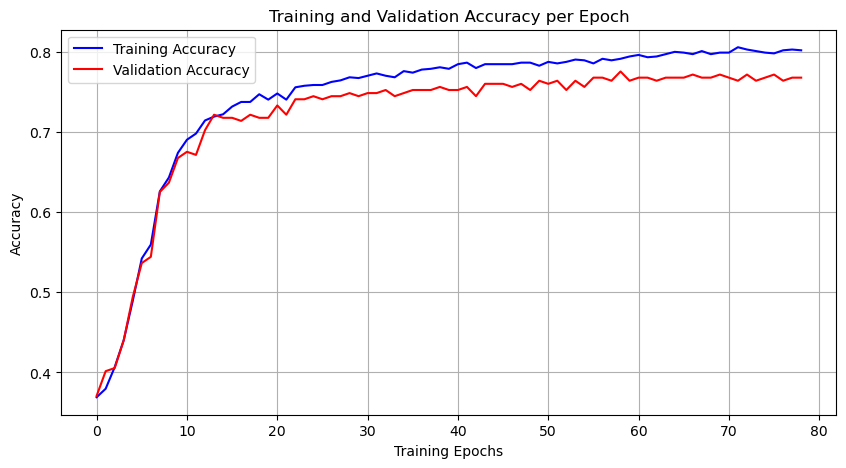

<Figure size 640x480 with 0 Axes>

In [32]:
epoch_range = range(len(val_accuracies))

plt.figure(figsize=(10, 5))
plt.plot(epoch_range, train_accuracies, label='Training Accuracy', linestyle='-', color='blue')
plt.plot(epoch_range, val_accuracies, label='Validation Accuracy', linestyle='-', color='red')

plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Training Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.grid(True)
plt.show()
plt.clf()

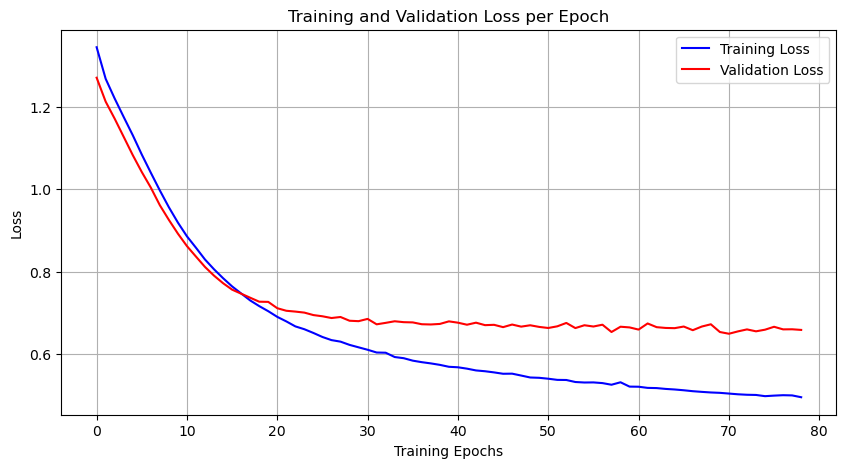

<Figure size 640x480 with 0 Axes>

In [33]:
epoch_range = range(len(val_losses))

plt.figure(figsize=(10, 5))
plt.plot(epoch_range, train_losses, label='Training Loss', linestyle='-', color='blue')
plt.plot(epoch_range, val_losses, label='Validation Loss', linestyle='-', color='red')

plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Training Epochs')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.show()
plt.clf()

In [34]:
y_pred, val_loss = test(best_model, test_loader, criterion)
test_acc = accuracy_score(y_test, y_pred)
accuracy_mlp = test_acc
test_acc

0.812933025404157

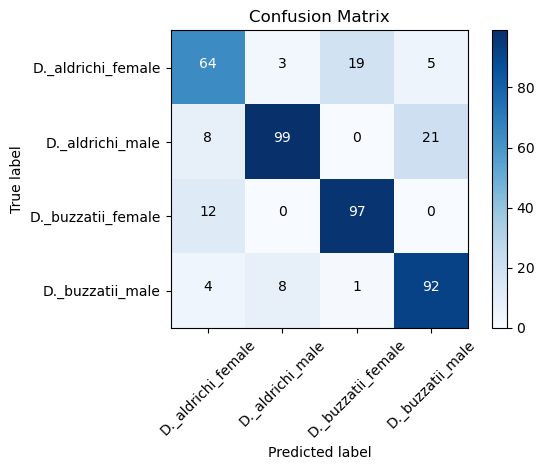

In [35]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(category_labels))
plt.xticks(tick_marks, category_labels, rotation=45)
plt.yticks(tick_marks, category_labels)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [36]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, target_names=category_labels, output_dict=True)

precision_recall_data = {
    "Category": [],
    "Precision": [],
    "Recall": []
}

for label in category_labels:
    precision_recall_data["Category"].append(label)
    precision_recall_data["Precision"].append(report[label]["precision"])
    precision_recall_data["Recall"].append(report[label]["recall"])

precision_recall_df_mlp = pd.DataFrame(precision_recall_data)

print(precision_recall_df_mlp)

             Category  Precision    Recall
0  D._aldrichi_female   0.727273  0.703297
1    D._aldrichi_male   0.900000  0.773438
2  D._buzzatii_female   0.829060  0.889908
3    D._buzzatii_male   0.779661  0.876190


## Conclusion

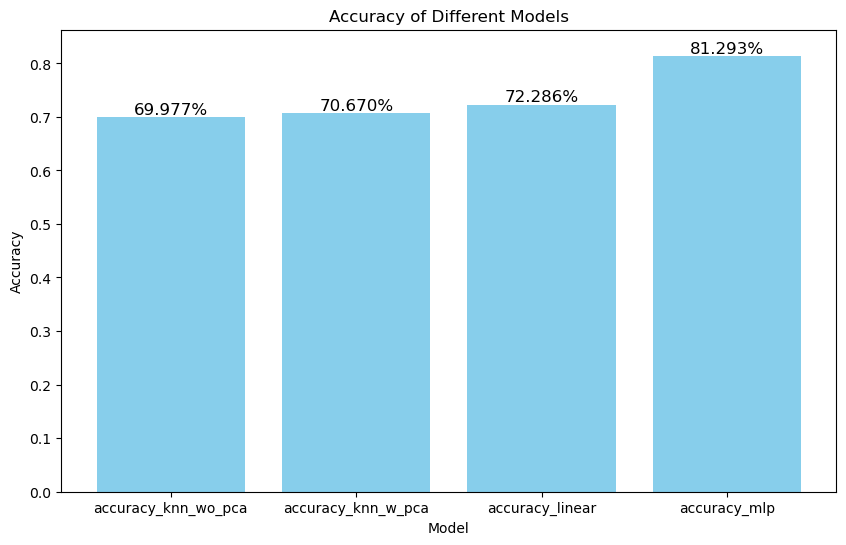

In [37]:
labels = ['accuracy_knn_wo_pca', 'accuracy_knn_w_pca', 'accuracy_linear', 'accuracy_mlp']

values = [accuracy_knn_wo_pca, accuracy_knn_w_pca, accuracy_linear, accuracy_mlp]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color='skyblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height * 100:.3f}%', ha='center', va='bottom', color='black', fontsize=12)

plt.title('Accuracy of Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')

plt.ylim(0, max(values) + 0.05)

plt.show()

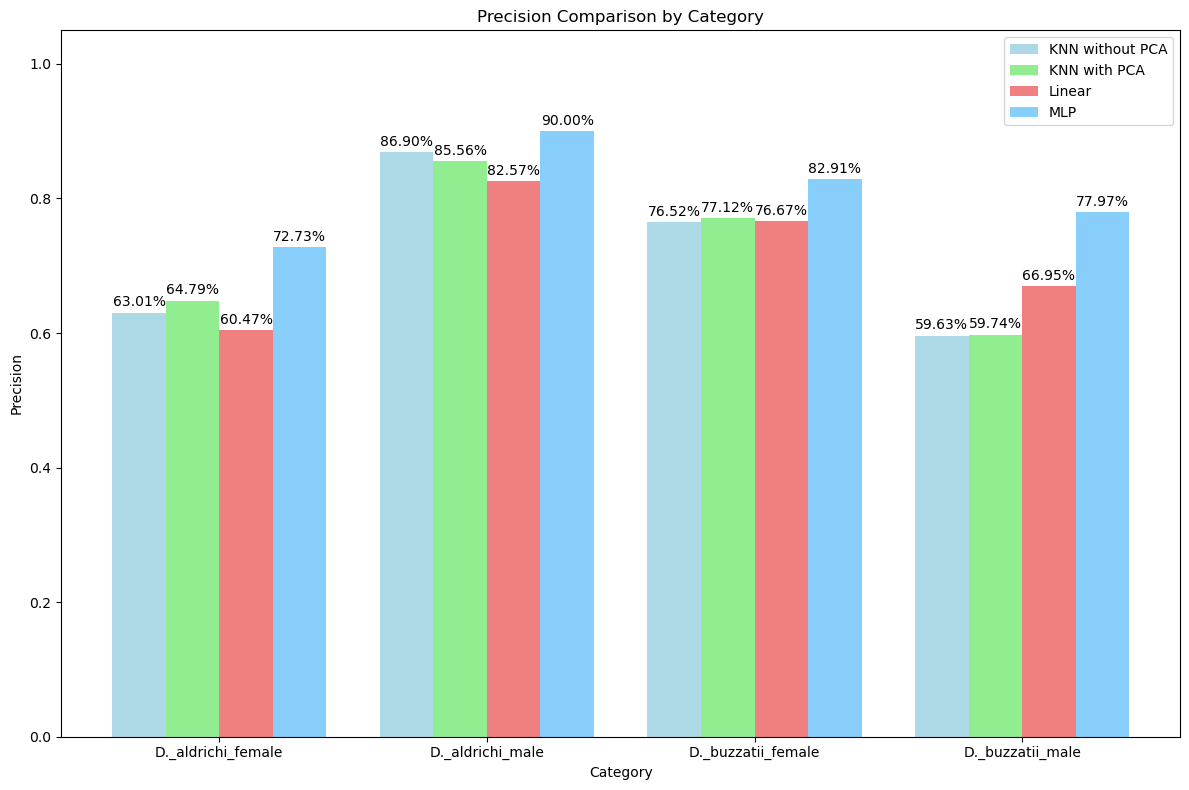

In [38]:
categories = precision_recall_df_knn_wo_pca['Category']
precision_values = [
    precision_recall_df_knn_wo_pca['Precision'],
    precision_recall_df_knn_w_pca['Precision'],
    precision_recall_df_linear['Precision'],
    precision_recall_df_mlp['Precision']
]

models = ['KNN without PCA', 'KNN with PCA', 'Linear', 'MLP']

colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightskyblue']

fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.2
index = np.arange(len(categories))

for i, precision in enumerate(precision_values):
    ax.bar(index + bar_width * i, precision, bar_width, label=models[i], color=colors[i])
    for j, value in enumerate(precision):
        ax.text(index[j] + bar_width * i, value + 0.005, f'{value * 100:.2f}%', ha='center', va='bottom', fontsize=10)

ax.set_title('Precision Comparison by Category')
ax.set_xlabel('Category')
ax.set_ylabel('Precision')
ax.set_xticks(index + bar_width * 1.5)
ax.set_xticklabels(categories)
ax.legend()

ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

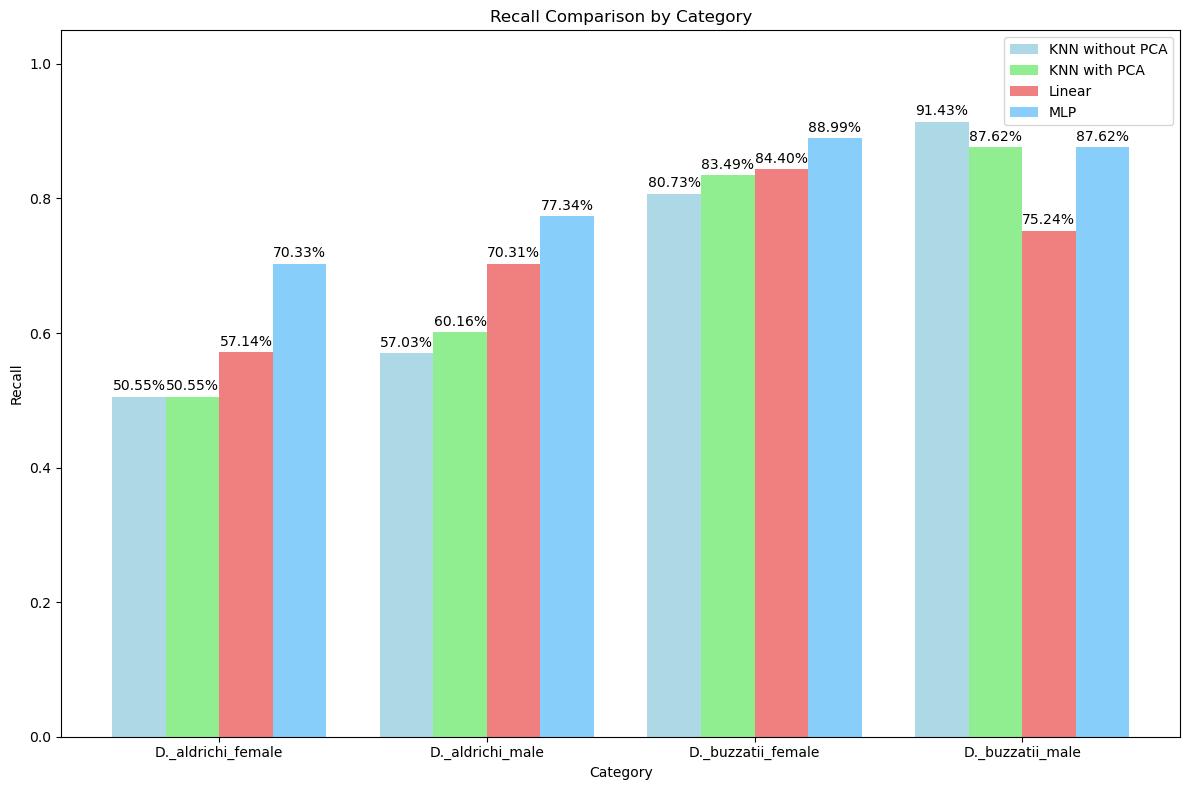

In [39]:
categories = precision_recall_df_knn_wo_pca['Category']
recall_values = [
    precision_recall_df_knn_wo_pca['Recall'],
    precision_recall_df_knn_w_pca['Recall'],
    precision_recall_df_linear['Recall'],
    precision_recall_df_mlp['Recall']
]

models = ['KNN without PCA', 'KNN with PCA', 'Linear', 'MLP']

colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightskyblue']

fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.2
index = np.arange(len(categories))

for i, recall in enumerate(recall_values):
    ax.bar(index + bar_width * i, recall, bar_width, label=models[i], color=colors[i])
    for j, value in enumerate(recall):
        ax.text(index[j] + bar_width * i, value + 0.005, f'{value * 100:.2f}%', ha='center', va='bottom', fontsize=10)

ax.set_title('Recall Comparison by Category')
ax.set_xlabel('Category')
ax.set_ylabel('Recall')
ax.set_xticks(index + bar_width * 1.5)
ax.set_xticklabels(categories)
ax.legend()

ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()